# Часть №1

In [ ]:
from google.colab import files
files.upload()

Saving kaggle-3.json to kaggle-3.json


{'kaggle-3.json': b'{"username":"dariapolyakova","key":"b36911d579b85bc910d47861bc368745"}'}

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import zipfile
import os

!kaggle datasets download -d soumikrakshit/images-for-style-transfer
!kaggle datasets download -d soumikrakshit/images-for-style-transfer

with zipfile.ZipFile("images-for-style-transfer.zip", "r") as zip_ref:
    zip_ref.extractall("images_for_style_transfer")

os.listdir("images_for_style_transfer")

Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/images-for-style-transfer
License(s): CC0-1.0
images-for-style-transfer.zip: Skipping, found more recently modified local copy (use --force to force download)
Dataset URL: https://www.kaggle.com/datasets/soumikrakshit/images-for-style-transfer
License(s): CC0-1.0
images-for-style-transfer.zip: Skipping, found more recently modified local copy (use --force to force download)


['Data', 'data']

In [ ]:
!pip install torch torchvision numpy matplotlib

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import save_image
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import matplotlib.pyplot as plt
import os

Посмотрим содержимое папки с изображениями:

In [ ]:
content_dir = "images_for_style_transfer/Data/TestCases"  # Папка с изображениями содержания
style_dir = "images_for_style_transfer/Data/Artworks"    # Папка с изображениями стиля

print("Content images:", os.listdir(content_dir))
print("Style images:", os.listdir(style_dir))

Content images: ['11334efc-2e2f-48e5-bae3-0f0d17c9b117.jpg', '5726.jpg', '22714.jpg', '33409544-33f9-408e-b081-cc64d2ceec60.jpg', 'fc37fb58-34e7-4e7b-bc4d-90787f04ba43.jpg', 'IMG_20170904_105301.jpg', '37864.jpg', '411820.jpg', 'geeky.jpg', '4682.jpg']
Style images: ['786051.jpg', '851497.jpg', '81842.jpg', '688916.jpg', '644443.jpg', '86092.jpg', '884561.jpg', '933391.jpg', '673478.png', '436348.jpg', '733367.png', '856047.jpg', '83995.jpg', '422652.jpg', '868625.jpg', '972994.jpg', '324310.jpg', '85343.jpg', '753342.jpg', '428771.jpg', '881100.png', '828002.png', '884203.jpg', '423786.jpg', '863449.jpg', '888440.jpg', '108700.jpg']


Загрузим данные:

In [ ]:
content_path = "images_for_style_transfer/Data/TestCases/5726.jpg"
style_path = "images_for_style_transfer/Data/Artworks/786051.jpg"

# Функция загрузки изображения
def load_image(image_path, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')

    # Изменение размера
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size if isinstance(size, (tuple, list)) else (size, size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = in_transform(image).unsqueeze(0)
    return image

content = load_image(content_path)
style = load_image(style_path, shape=(content.size(2), content.size(3)))

Определим модели и слои для переноса стиля. Для этого используем предобученную сеть VGG и определим функцию для извлечения слоев контента и стиля.

In [ ]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad_(False)

vgg.to("cuda" if torch.cuda.is_available() else "cpu")

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
# Выбор устройства
device = "cuda" if torch.cuda.is_available() else "cpu"
vgg = vgg.to(device)

In [ ]:
# Функция для извлечения слоев

def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

Теперь определим функции потерь.

In [ ]:
# Функции потерь

def calc_content_loss(target_features, content_features):
    return torch.mean((target_features - content_features) ** 2)

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

def calc_style_loss(target_grams, style_grams):
    style_loss = 0
    for layer in style_grams:
        target_gram = gram_matrix(target_grams[layer])
        style_gram = style_grams[layer]
        style_loss += torch.mean((target_gram - style_gram) ** 2)
    return style_loss

Реализуем цикл оптимизации и обучения

In [ ]:
# Переменная для оптимизации
target = content.clone().requires_grad_(True)
optimizer = optim.Adam([target], lr=0.001)

In [ ]:
# Определение веса потерь
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.8,
    'conv3_1': 0.5,
    'conv4_1': 0.3,
    'conv5_1': 0.1
}
content_weight = 1
style_weight = 1e3

In [ ]:
# Цикл оптимизации
device = "cuda" if torch.cuda.is_available() else "cpu"
content = content.to(device)
style = style.to(device)
target = target.to(device)
vgg = vgg.to(device)

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

for i in range(1, 1001):
    target_features = get_features(target, vgg)
    content_loss = calc_content_loss(target_features['conv4_2'], content_features['conv4_2'])

    style_loss = 0
    for layer in style_weights:
        target_gram = gram_matrix(target_features[layer])
        style_gram = style_grams[layer]
        layer_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        style_loss += layer_loss

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if i % 100 == 0:  # Сохранение каждые 100 итераций
        print(f"Iteration {i}, Total Loss: {total_loss.item()}")
        save_image(target.clone(), f"output_iteration_{i}.jpg")

Iteration 100, Total Loss: 22887864320.0
Iteration 200, Total Loss: 6787230208.0
Iteration 300, Total Loss: 3158880000.0
Iteration 400, Total Loss: 1978872192.0
Iteration 500, Total Loss: 1456861056.0
Iteration 600, Total Loss: 1171793408.0
Iteration 700, Total Loss: 990883328.0
Iteration 800, Total Loss: 863490752.0
Iteration 900, Total Loss: 767481792.0
Iteration 1000, Total Loss: 691927360.0


Посмотрим две исходные картинки (контента и стиля)

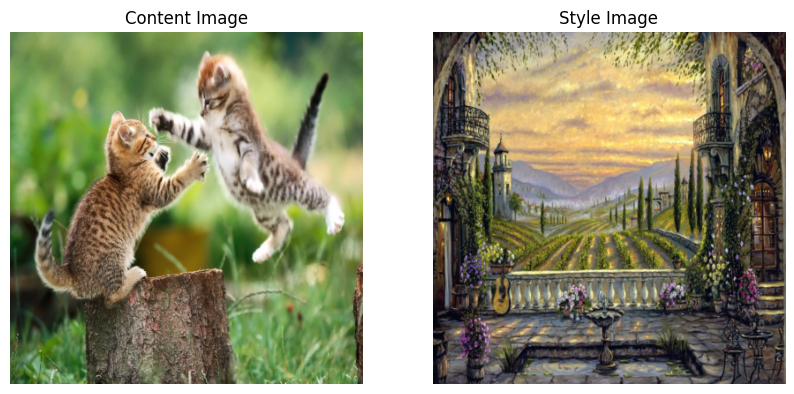

In [ ]:
# Отображение изображения контента
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im_convert(content))
plt.title("Content Image")
plt.axis("off")

# Отображение изображения стиля
plt.subplot(1, 2, 2)
plt.imshow(im_convert(style))
plt.title("Style Image")
plt.axis("off")

plt.show()

Визуализация результатов:

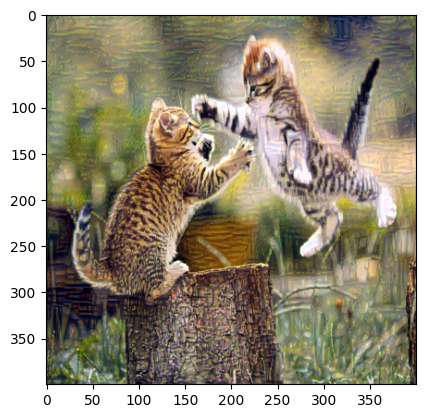

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * 0.5 + 0.5
    image = image.clip(0, 1)
    return image

plt.imshow(im_convert(target))
plt.show()

In [ ]:
from torchvision.utils import save_image
save_image(target, "stylized_image.jpg")

# Часть №2

Для выполнения задания я возьму CIFAR-10 — это стандартный датасет, состоящий из 60,000 цветных изображений размером 32×32 пикселя, разбитых на 10 классов.

Выполним загрузку и подготовку CIFAR-10

In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Трансформации для CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Нормализация к диапазону [-1, 1]
])

# Загрузка CIFAR-10
dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Files already downloaded and verified


Определим архитектуру GAN. Для CIFAR-10 изменим архитектуру, чтобы учесть цветные изображения размером  32×32×3.

In [21]:
# Генератор

import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 3, 32, 32)

In [22]:
# Дискриминатор

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 3 * 32 * 32)
        return self.model(x)

Теперь определим функцию потерь и оптимизаторов.

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Создание моделей
generator = Generator(noise_dim=100).to(device)
discriminator = Discriminator().to(device)

# Функция потерь
criterion = nn.BCELoss()

# Оптимизаторы
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [25]:
# Цикл обучения

import numpy as np

num_epochs = 50
noise_dim = 100

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)
        real_images = real_images.to(device)

        # Метки
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Обучение дискриминатора
        optimizer_D.zero_grad()
        outputs = discriminator(real_images)
        real_loss = criterion(outputs, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        fake_loss = criterion(outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Обучение генератора
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")

Epoch [1/50], d_loss: 0.3561243712902069, g_loss: 4.541352272033691
Epoch [2/50], d_loss: 0.1827254444360733, g_loss: 6.271048545837402
Epoch [3/50], d_loss: 0.056715041399002075, g_loss: 4.410069465637207
Epoch [4/50], d_loss: 0.12748034298419952, g_loss: 6.477527618408203
Epoch [5/50], d_loss: 0.20124554634094238, g_loss: 5.605740547180176
Epoch [6/50], d_loss: 0.4455718994140625, g_loss: 6.3508758544921875
Epoch [7/50], d_loss: 0.31363049149513245, g_loss: 4.147374153137207
Epoch [8/50], d_loss: 0.49275168776512146, g_loss: 3.4610867500305176
Epoch [9/50], d_loss: 0.7034765481948853, g_loss: 2.914677143096924
Epoch [10/50], d_loss: 0.8292465209960938, g_loss: 2.8241994380950928
Epoch [11/50], d_loss: 0.47121185064315796, g_loss: 2.763338088989258
Epoch [12/50], d_loss: 0.5984442234039307, g_loss: 2.3969602584838867
Epoch [13/50], d_loss: 0.7245724201202393, g_loss: 2.4154675006866455
Epoch [14/50], d_loss: 1.1555533409118652, g_loss: 2.389575481414795
Epoch [15/50], d_loss: 0.781128

Визуализация результатов:

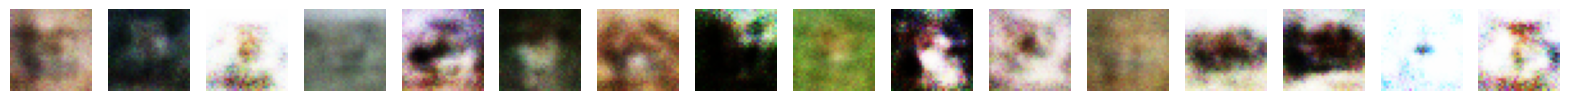

In [26]:
import matplotlib.pyplot as plt

def save_generated_images(generator, epoch, noise_dim=100, num_images=16):
    generator.eval()
    noise = torch.randn(num_images, noise_dim).to(device)
    fake_images = generator(noise)
    fake_images = fake_images.cpu().detach()

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, img in enumerate(fake_images):
        axes[i].imshow((img.permute(1, 2, 0) * 0.5 + 0.5).numpy())
        axes[i].axis('off')
    plt.show()
    generator.train()

save_generated_images(generator, num_epochs)